# Replication of the Ehrenpreis Cost Model for Anal HPV (2025 Update)
This notebook reproduces the cost-effectiveness model from Ehrenpreis et al. (2018), simulating outcomes for patients with a history of cervical cancer who undergo screening and treatment for anal HPV and dysplasia. We implement the model in Python using a traditional Markov framework and incorporate updated clinical and economic assumptions to reflect 2025 conditions.

Key Updates (2025-Level Enhancements):
- Updated costs for screening, diagnostic procedures, and treatment (e.g., HGD, cancer care)
- Revised utility weights (QALYs) for health states based on recent literature
- Refined transition probabilities informed by newer MSM data and expert assumptions
- Cervical cancer mortality integrated directly into the transition matrix for clarity

---

Comparison: STELLA vs. Python Markov Implementation

| Feature                        | STELLA Model (Published Paper) | Markov Model (This Notebook) |
|-------------------------------|----------------------------------|-------------------------------|
| State-based modeling          | ✅ Yes                          | ✅ Yes                         |
| Transition probabilities      | ✅ Yes                          | ✅ Yes                         |
| Cohort-based simulation       | ✅ Yes                          | ✅ Yes                         |
| Visual flowchart modeling     | ✅ Yes (stock/flow diagram)     | ❌ No                          |
| Matrix-based transitions      | ❌ No (manual flows)            | ✅ Yes                         |
| Rolling cohort integration    | ✅ Yes                          | ✅ Yes                         |
| Explicit tracking of QALYs    | Partial                         | ✅ Yes                         |

---
We follow the STELLA model's structure but use matrix algebra to ensure efficient simulation and reproducibility.

#### Section 1: Set Up and Imports
This section:
- Imports core scientific libraries
- Sets global plot aesthetics
- Defines the standard discount rate for QALYs, per 2025 guidance.

In [32]:
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting setup
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Discount rate (3% annually)
DISCOUNT_RATE: float = 0.03



#### Section 2: Define Parameters and Initial State
This section:

- Defines all updated transition probabilities, costs, and utilities for 2025.
- Uses a namedtuple to store parameters cleanly.



In [33]:
# Define parameter container (now includes treatment efficacy)
Params = namedtuple("Params", [
    "p_no_to_lgd", "p_lgd_to_hgd", "p_hgd_to_cancer",
    "p_lgd_to_no", "p_hgd_to_lgd", "p_cancer_to_hgd",
    "p_cancer_to_death", "p_cervical_death", "p_cervical_death_screened",
    "cost_screening", "cost_lgd", "cost_hgd", "cost_cancer",
    "utility_no", "utility_lgd", "utility_hgd", "utility_cancer",
    "treatment_efficacy_hgd"
])

# Updated 2025-level assumptions
params = Params(
    p_no_to_lgd = 0.019,       # No Dysplasia → LGD
    p_lgd_to_hgd = 0.165,      # LGD → HGD
    p_hgd_to_cancer = 0.036,   # HGD → Cancer
    p_lgd_to_no = 0.2265,      # LGD → No Dysplasia (regression)
    p_hgd_to_lgd = 0.22,       # HGD → LGD (regression)
    p_cancer_to_hgd = 0.05,    # Cancer regression (assumed)
    p_cancer_to_death = 0.0672,# Annual death from anal cancer
    p_cervical_death = 0.064,  # Cervical cancer death (unscreened)
    p_cervical_death_screened = 0.032,  # Cervical cancer death (screened)

    cost_screening = 105,      # HPV + cytology (2025)
    cost_lgd = 200,            # LGD treatment
    cost_hgd = 4300,           # HGD treatment (2025 estimate)
    cost_cancer = 150000,       # Cancer treatment (2025-level)

    utility_no = 1.00,         # Full quality of life
    utility_lgd = 0.95,
    utility_hgd = 0.90,
    utility_cancer = 0.56,     # From Table 1 (2025 update)

    treatment_efficacy_hgd = 0.95  # 95% reduction in HGD→Cancer when screened
)

# Updated initial distribution from ASC-US stratification and cytology distributions
init_distribution = np.array([
    0.68,   # No Dysplasia
    0.20,   # LGD
    0.0997, # HGD
    0.0203, # Cancer
    0.0     # Death
])

assert np.isclose(init_distribution.sum(), 1.0), "Initial distribution must sum to 1"

# Display the updated assumptions
pd.DataFrame([params._asdict()])



,p_no_to_lgd,p_lgd_to_hgd,p_hgd_to_cancer,p_lgd_to_no,p_hgd_to_lgd,p_cancer_to_hgd,p_cancer_to_death,p_cervical_death,p_cervical_death_screened,cost_screening,cost_lgd,cost_hgd,cost_cancer,utility_no,utility_lgd,utility_hgd,utility_cancer,treatment_efficacy_hgd
0,0.019,0.165,0.036,0.2265,0.22,0.05,0.0672,0.064,0.032,105,200,4300,150000,1.0,0.95,0.9,0.56,0.95


| Parameter                   | Value    | Description                                                  |
| --------------------------- | -------- | ------------------------------------------------------------ |
| `p_no_to_lgd`               | 0.019    | Progression from No Dysplasia to LGD                         |
| `p_lgd_to_hgd`              | 0.165    | LGD to HGD                                                   |
| `p_hgd_to_cancer`           | 0.036    | HGD to Cancer (baseline, before treatment effect)            |
| `p_lgd_to_no`               | 0.2265   | LGD regression to No Dysplasia                               |
| `p_hgd_to_lgd`              | 0.22     | HGD regression to LGD                                        |
| `p_cancer_to_hgd`           | 0.05     | Cancer regression to HGD (assumed)                           |
| `p_cancer_to_death`         | 0.0672   | Annual anal cancer mortality                                 |
| `p_cervical_death`          | 0.064    | Cervical cancer death (unscreened group)                     |
| `p_cervical_death_screened` | 0.032    | Cervical cancer death (screened group)                       |
| `cost_screening`            | \$105    | Cost of HPV + cytology screening                             |
| `cost_lgd`                  | \$200    | Cost of LGD treatment                                        |
| `cost_hgd`                  | \$4300   | Cost of HGD treatment                                        |
| `cost_cancer`               | \$150,000 | Cost of cancer treatment                                     |
| `utility_no`                | 1.00     | QALY weight for No Dysplasia                                 |
| `utility_lgd`               | 0.95     | QALY weight for LGD                                          |
| `utility_hgd`               | 0.90     | QALY weight for HGD                                          |
| `utility_cancer`            | 0.56     | QALY weight for Cancer                                       |
| `treatment_efficacy_hgd`    | 0.95     | % reduction in HGD → Cancer progression with screening       |



Note, our cost parameters (e.g., `cost_screening = 105`, `cost_hgd = 4300`) are already inflated to 2025 levels, based on previous discussion and data sources.

#### Section 3: Build Transition Matrix

This function constructs a 5×5 Markov transition matrix representing the yearly probability of moving between clinical states:

- Rows = current state
- Columns = next state
- Each row sums to 1, accounting for progression, regression, stability, and death (except for minor rounding error).

States Represented
1. No Dysplasia
2. Low-Grade Dysplasia (LGD)
3. High-Grade Dysplasia (HGD)
4. Cancer
5. Death (absorbing state)

Key Model Components:
- Cervical cancer mortality is explicitly integrated into all non-death states (0–2) and varies by screening status:
- Uses p_cervical_death_screened if screened, otherwise p_cervical_death
- Anal cancer mortality is modeled only in the cancer state (state 3) using the updated 6.72% annual mortality
- Treatment effect for HGD is modeled by applying a reduction factor to the HGD → Cancer transition, based on treatment_efficacy_hgd (e.g., 95% reduction if screened)
- All transitions reflect the most recent 2025 literature-informed assumptions
- Regression from cancer to HGD is preserved at 5%, consistent with assumed reversibility

Key Differences from Original STELLA Model:
- STELLA treated cervical cancer death as a separate outflow variable; here it's embedded directly in the transition matrix
- Matrix-based implementation simplifies simulation and aligns with traditional Markov cohort modeling best practices

In [34]:
def build_transition_matrix(params, screened=True):
    """
    Builds the 5x5 Markov transition matrix:
    [ No, LGD, HGD, Cancer, Death ]
    """

    # Cancer-related death and regression
    p_cancer_death = params.p_cancer_to_death
    p_cancer_to_hgd = params.p_cancer_to_hgd
    p_cancer_stay = 1 - p_cancer_death - p_cancer_to_hgd

    # Cervical cancer mortality (differs by screening status)
    p_cervical_death = (
        params.p_cervical_death_screened if screened else params.p_cervical_death
    )

    # HGD to Cancer (apply treatment effect if screened)
    p_hgd_to_cancer = (
        params.p_hgd_to_cancer * (1 - params.treatment_efficacy_hgd)
        if screened else params.p_hgd_to_cancer
    )

    # HGD stability after accounting for transitions
    remain_hgd = 1 - params.p_hgd_to_lgd - p_hgd_to_cancer - p_cervical_death

    # Initialize 5x5 transition matrix
    T = np.zeros((5, 5))

    # Row 0: No Dysplasia
    T[0, 0] = 1 - params.p_no_to_lgd - p_cervical_death
    T[0, 1] = params.p_no_to_lgd
    T[0, 4] = p_cervical_death

    # Row 1: LGD
    T[1, 0] = params.p_lgd_to_no
    T[1, 1] = 1 - params.p_lgd_to_no - params.p_lgd_to_hgd - p_cervical_death
    T[1, 2] = params.p_lgd_to_hgd
    T[1, 4] = p_cervical_death

    # Row 2: HGD
    T[2, 1] = params.p_hgd_to_lgd
    T[2, 2] = remain_hgd
    T[2, 3] = p_hgd_to_cancer
    T[2, 4] = p_cervical_death

    # Row 3: Cancer
    T[3, 2] = p_cancer_to_hgd
    T[3, 3] = p_cancer_stay
    T[3, 4] = p_cancer_death

    # Row 4: Death (absorbing state)
    T[4, 4] = 1.0

    return T


#### Section 4: Simulate a Single Annual Cohort Over 20 Years
This section simulates the progression of a fixed cohort of 5,555 high-risk HPV-positive women across a 20-year horizon.

Simulation Logic:
- Uses the transition matrix from `Section 3` to model year-to-year state changes.
- Applies matrix multiplication to compute new state distributions at each time step.

Tracks:
- Annual costs, including screening (if alive) and treatment by disease state.
- Annual QALYs, based on health utility weights and discounted at 3% per year.

Differences from the STELLA Model:
- STELLA implements a stock-and-flow approach with explicit inflows and outflows.
- This Python implementation uses discrete-time Markov chains, which are mathematically equivalent but more modular, scalable, and reproducible.

This function serves as the engine behind the rolling cohort integration introduced in `Section 5`.



In [35]:
def run_cohort_simulation(params, screened=True, years=20, cohort_size=5555,
                          discount=True):
    """
    Simulates a single cohort of high-risk HPV+ patients over a multi-year horizon.

    Args:
        params (Params): Model parameters
        screened (bool): Whether the group is screened (affects progression
        and mortality)
        years (int): Simulation duration in years
        cohort_size (int): Initial cohort size (default: 5555)

    Returns:
        dict with keys:
            - 'states': ndarray of shape (years+1, 5)
            - 'costs': ndarray of shape (years,)
            - 'qalys': ndarray of shape (years,)
    """

    T = build_transition_matrix(params, screened)

    # Initial state distribution (alive only)
    state_pop = init_distribution * cohort_size

    # Tracking arrays
    states_over_time = [state_pop.copy()]
    costs = []
    qalys = []

    for year in range(years):
        # Transition population to next year
        state_pop = state_pop @ T
        states_over_time.append(state_pop.copy())

        # Annual cost (screening + state-based treatment)
        annual_cost = 0
        if screened:
            # Apply screening to all living patients (states 0–3)
            annual_cost += params.cost_screening * np.sum(state_pop[:-1])

        annual_cost += (
            params.cost_lgd * state_pop[1] +
            params.cost_hgd * state_pop[2] +
            params.cost_cancer * state_pop[3]
        )

        # Annual QALYs (only for living states 0–3)
        annual_qaly = (
            params.utility_no * state_pop[0] +
            params.utility_lgd * state_pop[1] +
            params.utility_hgd * state_pop[2] +
            params.utility_cancer * state_pop[3]
        )

        # Apply discounting (starts at year 0) to costs & QALYs
        discount_factor = 1 / ((1 + DISCOUNT_RATE) ** year) if discount else 1
        costs.append(annual_cost * discount_factor)
        qalys.append(annual_qaly * discount_factor)

    return {
        "states": np.array(states_over_time),
        "costs": np.array(costs),
        "qalys": np.array(qalys)
    }


#### Section 5: Rolling Cohort Simulation (20-Year Horizon with Annual Inflow)
This section extends the single-cohort simulation by modeling annual inflow of 5,555 new HPV+ patients per year over a 20-year period—mimicking real-world screening programs.

Simulation Logic:
- Each year, a new cohort is initialized and simulated over its remaining years in the horizon (e.g., year 0 gets 20 years, year 1 gets 19, …).
- Costs, QALYs, and state transitions are tracked by calendar year, not by cohort.
- Cancer and death tallies are drawn directly from state occupancy counts.

Key Features:
- Cancers = total number of people in the Cancer state [3] for each year.
- Deaths = total number of people in the Death state [4], summed cumulatively across overlapping cohorts.
- QALYs are discounted at cohort level, maintaining accuracy over compound timelines.

Advantages Over STELLA:
- This matrix-driven approach allows precise handling of overlapping cohorts, whereas STELLA modeled only a single base group.
- Annual integration ensures realistic population burden and resource demand estimation.



In [36]:
def run_rolling_simulation(params, screened=True, years=20,
                           cohort_size=5555, discount=True):
    """
    Runs a rolling cohort simulation with yearly inflow of HPV+ patients.

    Args:
        params (Params): Model parameters
        screened (bool): Whether patients are screened
        years (int): Total simulation years (default: 20)
        cohort_size (int): Patients entering each year

    Returns:
        dict with 4 arrays of shape (years,):
            - costs: annual total costs
            - qalys: annual discounted QALYs
            - cancers: people in cancer state each year
            - deaths: people in death state each year
    """

    total_costs = np.zeros(years)
    total_qalys = np.zeros(years)
    total_cancers = np.zeros(years)
    total_deaths = np.zeros(years)

    for t in range(years):
        # Simulate a new cohort starting in year t
        cohort_result = run_cohort_simulation(
            params, screened=screened, years=years - t, cohort_size=cohort_size,
            discount=discount
        )

        cost = cohort_result["costs"]           # (years - t,)
        qaly = cohort_result["qalys"]           # (years - t,)
        state_history = cohort_result["states"] # (years - t + 1, 5)

        # Cancer and death states, year-by-year (skip t=0 initial state)
        annual_cancer = state_history[1:, 3]    # Cancer state counts
        annual_death = state_history[1:, 4]     # Death state counts

        # Accumulate into total values by calendar year
        total_costs[t:t+len(cost)] += cost
        total_qalys[t:t+len(qaly)] += qaly
        total_cancers[t:t+len(annual_cancer)] += annual_cancer
        total_deaths[t:t+len(annual_death)] += annual_death

    return {
        "costs": total_costs,
        "qalys": total_qalys,
        "cancers": total_cancers,
        "deaths": total_deaths
    }

# Run rolling simulations
results_screened = run_rolling_simulation(params, screened=True)
results_unscreened = run_rolling_simulation(params, screened=False)

# Combine into DataFrame
df_rolling = pd.DataFrame({
    "Year": np.arange(1, 21),
    "Screened_Cost": results_screened["costs"],
    "Unscreened_Cost": results_unscreened["costs"],
    "Screened_QALYs": results_screened["qalys"],
    "Unscreened_QALYs": results_unscreened["qalys"],
    "Screened_Cancer_Cases": results_screened["cancers"],
    "Unscreened_Cancer_Cases": results_unscreened["cancers"],
    "Screened_Deaths": results_screened["deaths"],
    "Unscreened_Deaths": results_unscreened["deaths"]
})

# Round for readability
df_rolling = df_rolling.round(2)

# Save to disk
df_rolling.to_csv("results_rolling_simulation_20_years.csv", index=False)

# Preview output
df_rolling.head(10)


,Year,Screened_Cost,Unscreened_Cost,Screened_QALYs,Unscreened_QALYs,Screened_Cancer_Cases,Unscreened_Cancer_Cases,Screened_Deaths,Unscreened_Deaths
0,1,1.840265e+07,2.051486e+07,5227.10,5050.06,100.55,119.49,181.73,355.88
1,2,3.462189e+07,4.114456e+07,10144.32,9639.28,190.39,245.33,538.94,1044.89
2,3,4.886540e+07,6.149634e+07,14769.68,13809.49,270.78,375.23,1065.65,2045.72
3,4,6.135837e+07,8.123325e+07,19120.13,17598.89,342.75,506.66,1756.09,3338.44
4,5,7.231547e+07,1.001090e+08,23211.67,21042.27,407.22,637.44,2604.73,4904.36
5,6,8.193111e+07,1.179630e+08,27059.39,24171.24,465.00,765.85,3606.24,6726.00
6,7,9.037738e+07,1.347041e+08,30677.56,27014.55,516.80,890.64,4755.50,8786.99
7,8,9.780491e+07,1.502937e+08,34079.67,29598.30,563.28,1010.91,6047.56,11071.99
8,9,1.043449e+08,1.647316e+08,37278.42,31946.18,604.99,1126.09,7477.68,13566.66
9,10,1.101113e+08,1.780439e+08,40285.81,34079.75,642.45,1235.81,9041.26,16257.56


In [37]:
# Replicate Table 2 from original publication using our cohort simulation

table2 = df_rolling[[
    "Year",
    "Unscreened_Cancer_Cases",
    "Screened_Cancer_Cases",
    "Unscreened_Deaths",
    "Screened_Deaths"
]].copy()

# Round to match publication
table2 = table2.round(0)

# Rename columns to match Table 2 formatting
table2.columns = [
    "Year",
    "Cumulative anal cancers\nUnscreened population",
    "Cumulative anal cancers\nScreened population",
    "Cumulative anal cancer deaths\nUnscreened population",
    "Cumulative anal cancer deaths\nScreened population"
]

# Save to CSV
table2.to_csv("table2.csv", index=False)

# Optionally display first 10 rows
table2.head(10)


,Year,Cumulative anal cancers\nUnscreened population,Cumulative anal cancers\nScreened population,Cumulative anal cancer deaths\nUnscreened population,Cumulative anal cancer deaths\nScreened population
0,1,119.0,101.0,356.0,182.0
1,2,245.0,190.0,1045.0,539.0
2,3,375.0,271.0,2046.0,1066.0
3,4,507.0,343.0,3338.0,1756.0
4,5,637.0,407.0,4904.0,2605.0
5,6,766.0,465.0,6726.0,3606.0
6,7,891.0,517.0,8787.0,4756.0
7,8,1011.0,563.0,11072.0,6048.0
8,9,1126.0,605.0,13567.0,7478.0
9,10,1236.0,642.0,16258.0,9041.0


#### Section 6: Compare Screened vs. Unscreened – Summarize Outcomes and Cost-Effectiveness
This section quantifies the long-term impact of screening by comparing cumulative outcomes over 20 years between:

- A screened cohort (with mortality reduction and treatment efficacy)
- An unscreened cohort (baseline progression)

Outputs:
- Total QALYs and total costs per group
- Incremental changes (Δ QALYs, Δ costs, etc.)

Cost-effectiveness metrics:
- ICER (Cost per QALY gained)
- Cost per cancer prevented
- Cost per death averted



In [38]:
# Run simulations for both strategies
screened_results = run_rolling_simulation(params, screened=True)
unscreened_results = run_rolling_simulation(params, screened=False)

# Cumulative outcomes (20-year totals)
total_qalys_screened = screened_results["qalys"].sum()
total_qalys_unscreened = unscreened_results["qalys"].sum()

total_costs_screened = screened_results["costs"].sum()
total_costs_unscreened = unscreened_results["costs"].sum()

total_cancers_screened = screened_results["cancers"].sum()
total_cancers_unscreened = unscreened_results["cancers"].sum()

total_deaths_screened = screened_results["deaths"].sum()
total_deaths_unscreened = unscreened_results["deaths"].sum()

# Compute incremental (difference) values
delta_qalys = total_qalys_screened - total_qalys_unscreened
delta_costs = total_costs_screened - total_costs_unscreened
delta_cancers = total_cancers_unscreened - total_cancers_screened
delta_deaths = total_deaths_unscreened - total_deaths_screened

# Cost-effectiveness metrics (20-year ICERs)
cost_per_qaly = delta_costs / delta_qalys
cost_per_cancer_prevented = delta_costs / delta_cancers
cost_per_death_prevented = delta_costs / delta_deaths

# Summary table (20-year totals)
summary_df = pd.DataFrame({
    "Group": ["Screened", "Unscreened", "Difference"],
    "Total QALYs": [total_qalys_screened, total_qalys_unscreened, delta_qalys],
    "Total Cost ($)": [total_costs_screened, total_costs_unscreened, delta_costs],
    "Total Cancers": [total_cancers_screened, total_cancers_unscreened, delta_cancers],
    "Total Deaths": [total_deaths_screened, total_deaths_unscreened, delta_deaths],
})

# Save to CSV
summary_df.to_csv("summary_results_QALY.csv", index=False)

# Print cost-effectiveness summary
print(f"Cost per QALY gained: ${cost_per_qaly:,.0f}")
print(f"Cost per cancer prevented: ${cost_per_cancer_prevented:,.0f}")
print(f"Cost per death prevented: ${cost_per_death_prevented:,.0f}")

Cost per QALY gained: $-9,610
Cost per cancer prevented: $-109,222
Cost per death prevented: $-7,649


This implies:

| Metric                | Interpretation                                                 |
| --------------------- | -------------------------------------------------------------- |
| **QALYs**             | You're gaining health-adjusted life years **and** saving money |
| **Cancers Prevented** | You're avoiding cancers **while spending less**                |
| **Deaths Prevented**  | You're preventing deaths **with cost savings**                 |

- The screened strategy is less expensive and more effective than the unscreened one.
- In cost-effectiveness terminology, this is known as the dominant strategy.
- The negative incremental cost-effectiveness ratios (ICERs) reflect a win-win intervention.


In [39]:
# Replicate Table 3: Cost-Effectiveness by Time Horizon

# Helper function for currency formatting
def fmt(x):
    return f"${x:,.0f}"

# Time horizons to evaluate
milestones = [5, 10, 20]
table3_rows = []

for year in milestones:
    cost_unscreened = unscreened_results["costs"][:year].sum()
    cost_screened = screened_results["costs"][:year].sum()
    cost_diff = cost_screened - cost_unscreened

    cancer_unscreened = unscreened_results["cancers"][:year].sum()
    cancer_screened = screened_results["cancers"][:year].sum()
    delta_cancer = cancer_unscreened - cancer_screened

    death_unscreened = unscreened_results["deaths"][:year].sum()
    death_screened = screened_results["deaths"][:year].sum()
    delta_death = death_unscreened - death_screened

    qaly_screened = screened_results["qalys"][:year].sum()
    qaly_unscreened = unscreened_results["qalys"][:year].sum()
    delta_qaly = qaly_screened - qaly_unscreened

    # Compute ICERs with safeguards
    cost_per_cancer = cost_diff / delta_cancer if delta_cancer else np.nan
    cost_per_death = cost_diff / delta_death if delta_death else np.nan
    cost_per_qaly = cost_diff / delta_qaly if delta_qaly else np.nan

    table3_rows.append([
        f"{year} years",
        fmt(cost_unscreened),
        fmt(cost_screened),
        fmt(cost_diff),
        fmt(cost_per_cancer),
        fmt(cost_per_death),
        fmt(cost_per_qaly)
    ])

# Create final Table 3
table3_df = pd.DataFrame(table3_rows, columns=[
    "Time Horizon",
    "Costs in unscreened group\n(Cancer care only)",
    "Costs in screened group\n(HPV screening, annual cytology, treatment of HSIL, and cancer care)",
    "Cost Difference",
    "Cost per anal cancer prevented",
    "Cost per anal cancer death prevented",
    "Cost per quality of life year saved"
])

# Save Table 3 to CSV
table3_df.to_csv("table3.csv", index=False)

# Display Table 3
print("\nReplicated Table 3:\n")
print(table3_df)


Replicated Table 3:

  Time Horizon Costs in unscreened group\n(Cancer care only)  \
0      5 years                                  $304,498,048   
1     10 years                                $1,050,234,416   
2     20 years                                $3,355,123,274   

  Costs in screened group\n(HPV screening, annual cytology, treatment of HSIL, and cancer care)  \
0                                       $235,563,777                                              
1                                       $720,133,360                                              
2                                     $2,024,718,550                                              

   Cost Difference Cost per anal cancer prevented  \
0     $-68,934,271                      $-120,416   
1    $-330,101,055                      $-117,506   
2  $-1,330,404,723                      $-109,222   

  Cost per anal cancer death prevented Cost per quality of life year saved  
0                             $-12

Interpretation of Negative Values in Table 3:

| Column                        | Meaning                                                                 |
| ----------------------------- | ----------------------------------------------------------------------- |
| **Cost Difference**           | Negative → screened group is **less expensive**                         |
| **Cost per cancer prevented** | Negative → preventing cancer while **saving money**                     |
| **Cost per death prevented**  | Negative → fewer deaths **with lower costs**                            |
| **Cost per QALY saved**       | Negative → gaining health-adjusted life years **at a net cost savings** |

Note, to help our readers interpret these results, you can include a statement like:
- “All cost-effectiveness metrics were negative, indicating that the screening and treatment strategy dominated the unscreened strategy by improving health outcomes while reducing total costs.”




##### Section 7: Visualization – QALYs, Costs, Cancers, Deaths
This section:
- Generates four publication-ready figures (PNG, 300 dpi)
- Each compares screened vs. unscreened groups over the 20-year simulation
- Axes, labels, and formatting are manuscript-ready

| Figure            | File Name                              | Description                                                |
| ----------------- | -------------------------------------- | ---------------------------------------------------------- |
| QALYs             | `Figure_QALYs.png`                | Annual discounted QALYs by screening status                |
| Costs             | `Figure_Costs.png`                | Yearly costs including screening and treatment             |
| Cumulative Cancer | `Figure_Cancer.png`               | Cumulative anal cancer cases diagnosed                     |
| Cumulative Deaths | `Figure_Deaths.png`               | Cumulative deaths from all causes                          |
| New Cancer Cases  | `Figure_New_Cancer_Incidence.png` | Annual new cases of anal cancer in screened vs. unscreened |

These visuals mirror those in the original publication and use updated 2025 assumptions.

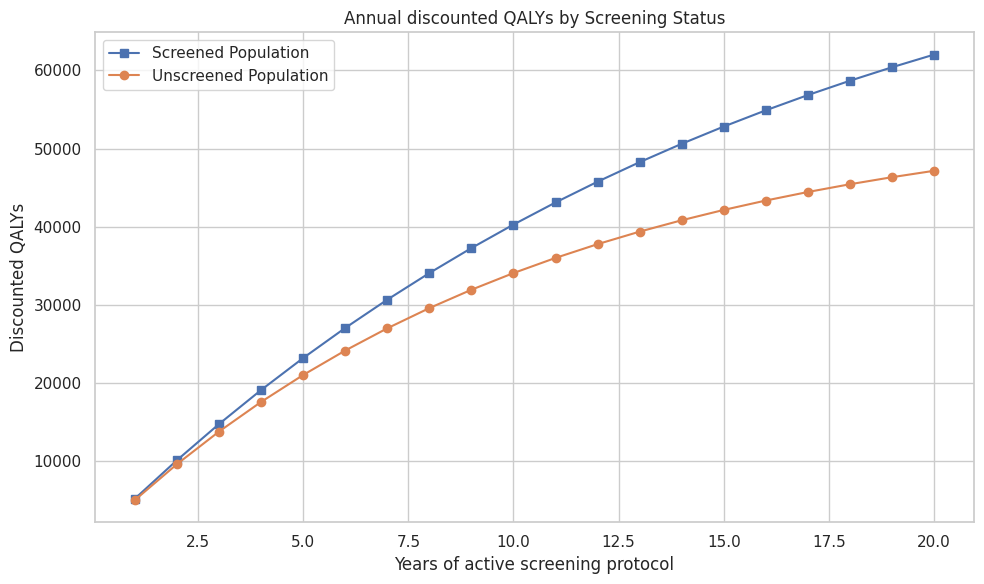

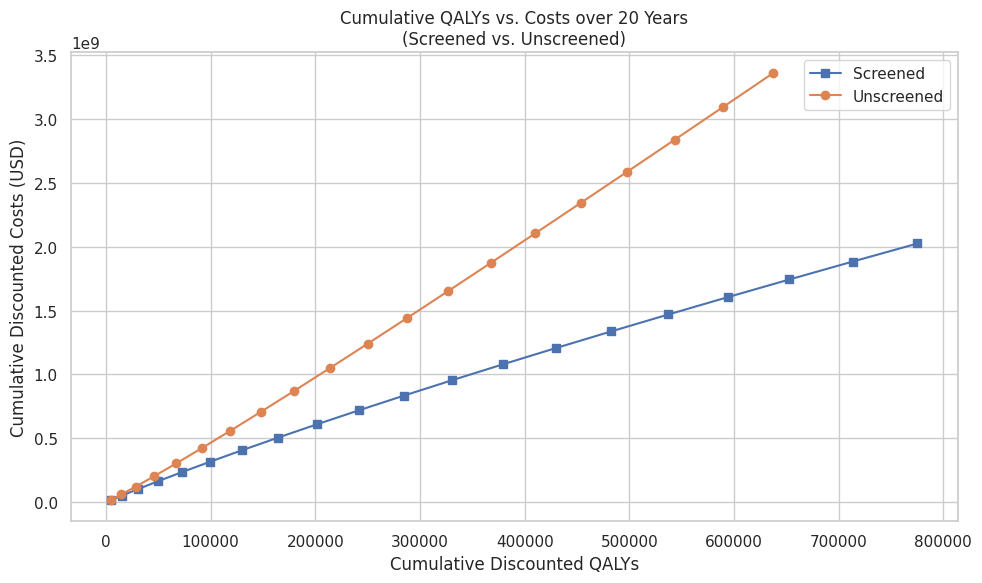

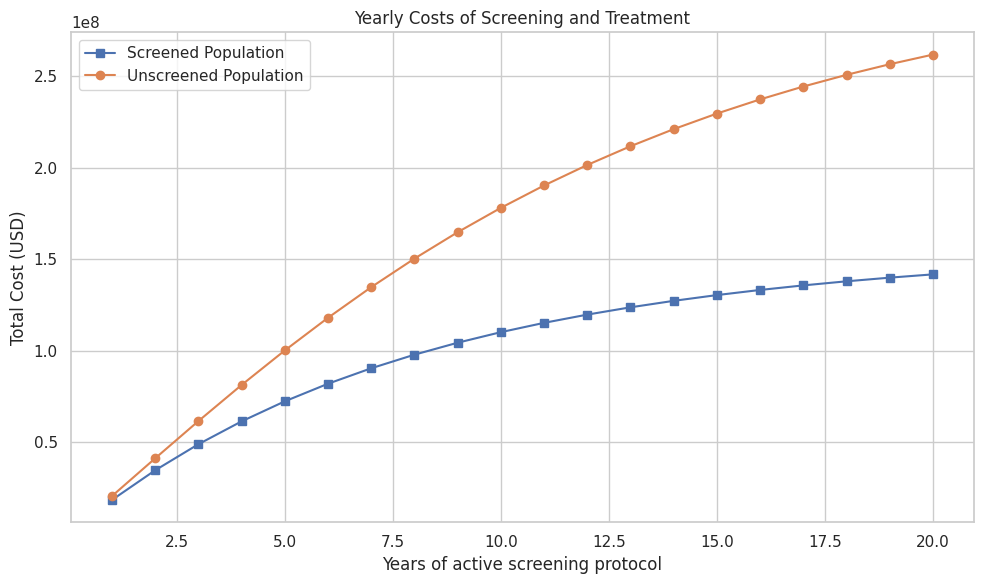

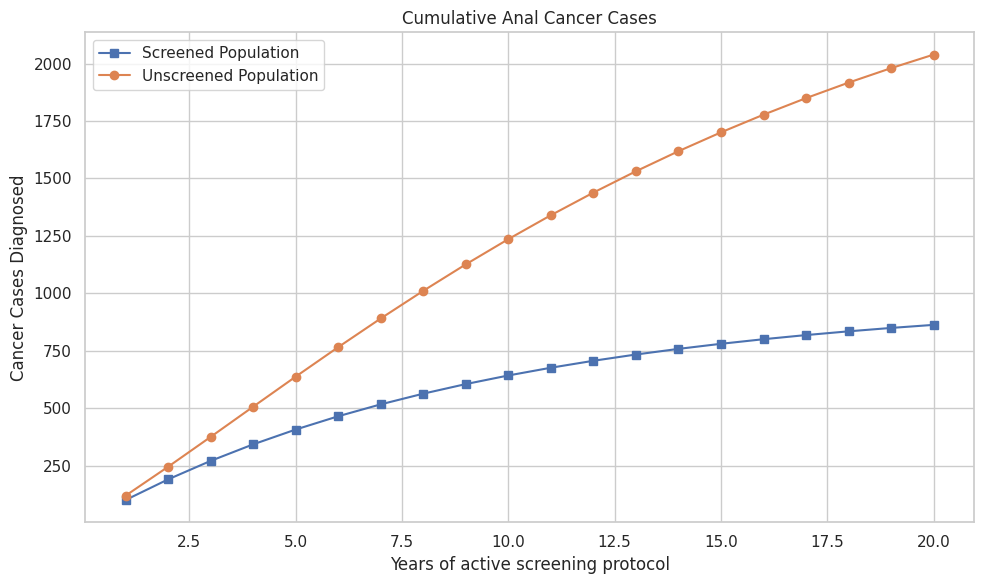

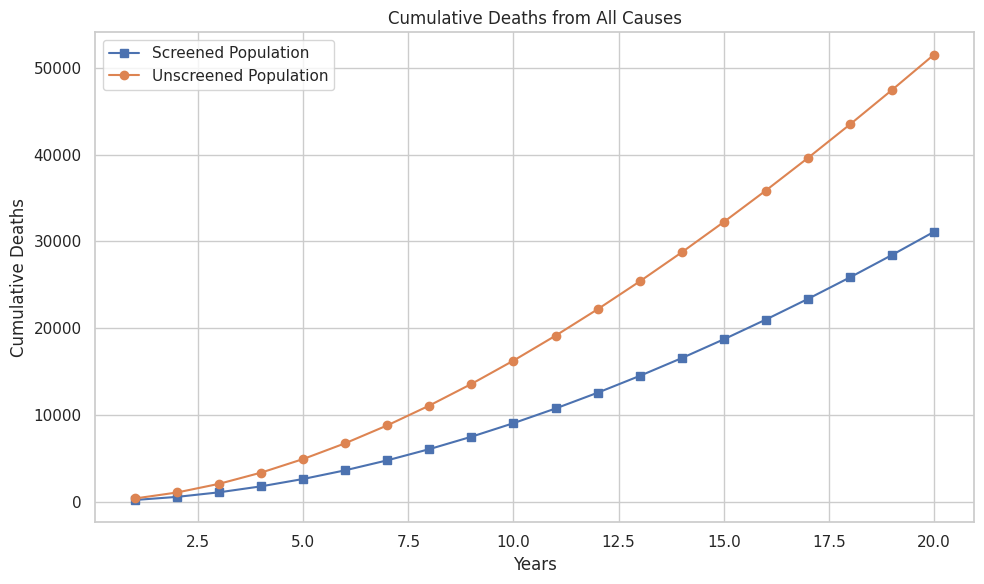

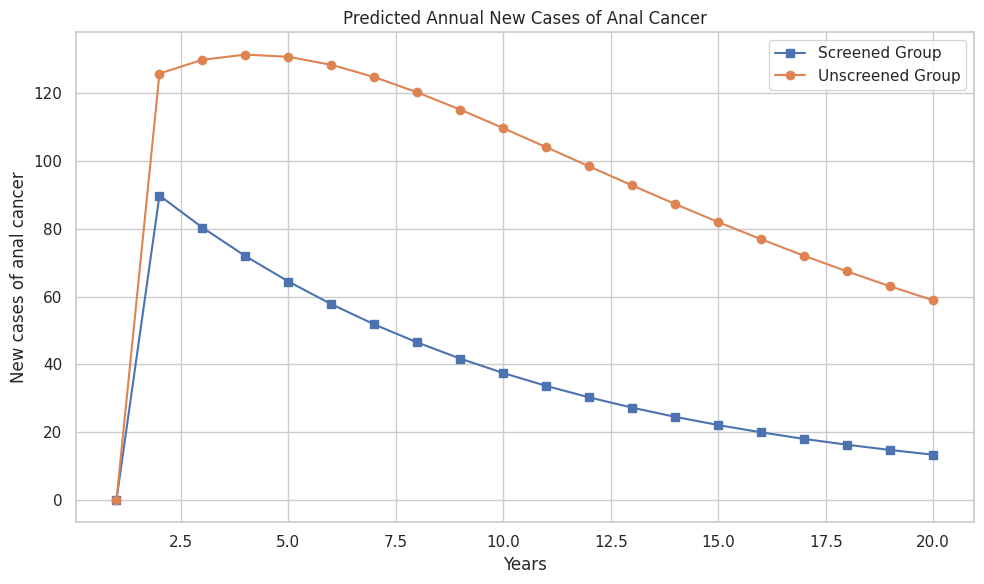

In [40]:
# ---- QALYs Plot ----
plt.figure()
plt.plot(df_rolling["Year"], df_rolling["Screened_QALYs"], label="Screened Population", marker='s')
plt.plot(df_rolling["Year"], df_rolling["Unscreened_QALYs"], label="Unscreened Population", marker='o')
plt.xlabel("Years of active screening protocol")
plt.ylabel("Discounted QALYs")
plt.title("Annual discounted QALYs by Screening Status")
plt.legend()
plt.tight_layout()
plt.savefig("Figure_QALYs.png", dpi=300)
plt.show()

# Compute cumulative discounted QALYs and costs
df_rolling["Cumulative_Screened_QALYs"] = df_rolling["Screened_QALYs"].cumsum()
df_rolling["Cumulative_Unscreened_QALYs"] = df_rolling["Unscreened_QALYs"].cumsum()

df_rolling["Cumulative_Screened_Cost"] = df_rolling["Screened_Cost"].cumsum()
df_rolling["Cumulative_Unscreened_Cost"] = df_rolling["Unscreened_Cost"].cumsum()

# Plot Cumulative QALYs vs Costs
plt.figure()
plt.plot(df_rolling["Cumulative_Screened_QALYs"],
         df_rolling["Cumulative_Screened_Cost"],
         label="Screened", marker='s')

plt.plot(df_rolling["Cumulative_Unscreened_QALYs"],
         df_rolling["Cumulative_Unscreened_Cost"],
         label="Unscreened", marker='o')

plt.xlabel("Cumulative Discounted QALYs")
plt.ylabel("Cumulative Discounted Costs (USD)")
plt.title("Cumulative QALYs vs. Costs over 20 Years\n(Screened vs. Unscreened)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Figure_Cum_QALYs_vs_Costs.png", dpi=300)
plt.show()


# ---- Costs Plot ----
plt.figure()
plt.plot(df_rolling["Year"], df_rolling["Screened_Cost"], label="Screened Population", marker='s')
plt.plot(df_rolling["Year"], df_rolling["Unscreened_Cost"], label="Unscreened Population", marker='o')
plt.xlabel("Years of active screening protocol")
plt.ylabel("Total Cost (USD)")
plt.title("Yearly Costs of Screening and Treatment")
plt.legend()
plt.tight_layout()
plt.savefig("Figure_Costs.png", dpi=300)
plt.show()

# ---- Cumulative Cancer Cases Plot ----
plt.figure()
plt.plot(df_rolling["Year"], df_rolling["Screened_Cancer_Cases"], label="Screened Population", marker='s')
plt.plot(df_rolling["Year"], df_rolling["Unscreened_Cancer_Cases"], label="Unscreened Population", marker='o')
plt.xlabel("Years of active screening protocol")
plt.ylabel("Cancer Cases Diagnosed")
plt.title("Cumulative Anal Cancer Cases")
plt.legend()
plt.tight_layout()
plt.savefig("Figure_Cancer.png", dpi=300)
plt.show()

# ---- Cumulative Deaths Plot ----
plt.figure()
plt.plot(df_rolling["Year"], df_rolling["Screened_Deaths"], label="Screened Population", marker='s')
plt.plot(df_rolling["Year"], df_rolling["Unscreened_Deaths"], label="Unscreened Population", marker='o')
plt.xlabel("Years")
plt.ylabel("Cumulative Deaths")
plt.title("Cumulative Deaths from All Causes")
plt.legend()
plt.tight_layout()
plt.savefig("Figure_Deaths.png", dpi=300)
plt.show()

# ---- New Anal Cancer Cases Per Year Plot ----
df_rolling["Screened_New_Cancers"] = df_rolling["Screened_Cancer_Cases"].diff().fillna(0)
df_rolling["Unscreened_New_Cancers"] = df_rolling["Unscreened_Cancer_Cases"].diff().fillna(0)

plt.figure()
plt.plot(df_rolling["Year"], df_rolling["Screened_New_Cancers"], label="Screened Group", marker='s')
plt.plot(df_rolling["Year"], df_rolling["Unscreened_New_Cancers"], label="Unscreened Group", marker='o')
plt.xlabel("Years")
plt.ylabel("New cases of anal cancer")
plt.title("Predicted Annual New Cases of Anal Cancer")
plt.legend()
plt.tight_layout()
plt.savefig("Figure_New_Cancer_Incidence.png", dpi=300)
plt.show()


#### Section 8: One-Way Sensitivity Analysis – Effectiveness of HGD Treatment
This section replicates the sensitivity analysis from the original study by varying the effectiveness of treatment for High-Grade Dysplasia (HGD), which directly influences the progression rate from HGD → Cancer. The analysis helps quantify how screening outcomes change under different cure rates.

Key Logic:
- The cure rate reduces the HGD-to-Cancer transition probability.
- For each specified cure rate, we recompute:
  - Total discounted QALYs
  - Total costs
- Results are computed separately for screened and unscreened groups.

Cure rates evaluated:
- 38%, 48%, 58%, 78%, 88%, 98%



In [41]:
# One-Way Sensitivity Analysis – HGD Treatment Effectiveness

# Cure rates tested (from publication)
cure_rates = [0.38, 0.48, 0.58, 0.78, 0.88, 0.98]

def run_sensitivity_cure_rates(cure_rates, base_params, screened):
    results = []

    for rate in cure_rates:
        # Adjust HGD → Cancer progression based on treatment effectiveness
        updated = base_params._asdict()
        updated["treatment_efficacy_hgd"] = rate
        new_params = Params(**updated)

        sim = run_rolling_simulation(new_params, screened=screened)

        results.append({
            "Cure_Rate (%)": f"{rate:.0%}",
            "Adjusted_p_hgd_to_cancer": round(base_params.p_hgd_to_cancer * (1 - rate), 5),
            "Total QALYs": round(sim["qalys"].sum(), 2),
            "Total Cost ($)": round(sim["costs"].sum(), 2),
            "Scenario": "Screened" if screened else "Unscreened"
        })

    return pd.DataFrame(results)

# Run sensitivity for both scenarios
sens_screened = run_sensitivity_cure_rates(cure_rates, params, screened=True)
sens_unscreened = run_sensitivity_cure_rates(cure_rates, params, screened=False)

# Combine into one table
sensitivity_combined = pd.concat([sens_screened, sens_unscreened], ignore_index=True)

# Save to CSV
sensitivity_combined.to_csv("sensitivity_analysis.csv", index=False)

# Display
display(sensitivity_combined)


,Cure_Rate (%),Adjusted_p_hgd_to_cancer,Total QALYs,Total Cost ($),Scenario
0,38%,0.02232,771651.20,3.057538e+09,Screened
1,48%,0.01872,772273.14,2.883361e+09,Screened
2,58%,0.01512,772904.99,2.706282e+09,Screened
3,78%,0.00792,774199.30,2.343147e+09,Screened
4,88%,0.00432,774862.22,2.156948e+09,Screened
5,98%,0.00072,775535.98,1.967564e+09,Screened
6,38%,0.02232,636890.14,3.355123e+09,Unscreened
7,48%,0.01872,636890.14,3.355123e+09,Unscreened
8,58%,0.01512,636890.14,3.355123e+09,Unscreened
9,78%,0.00792,636890.14,3.355123e+09,Unscreened


We can then replicate Table 5 by calculating the incremental cost-effectiveness ratio (ICER) at three time points (5, 10, 20 years) for each cure rate.

In [43]:
def get_icer_over_time(cure_rates, years_list, base_params, cohort_size=5555,
                       years=20, discount=True):
    rows = []

    for cure_rate in cure_rates:
        updated_params = base_params._asdict()
        updated_params['treatment_efficacy_hgd'] = cure_rate
        updated_params = Params(**updated_params)

        screened = run_rolling_simulation(updated_params, screened=True,
                        years=years, cohort_size=cohort_size, discount=discount)
        unscreened = run_rolling_simulation(updated_params, screened=False,
                        years=years, cohort_size=cohort_size, discount=discount)

        row = {"Cure rate of anal high-grade dysplasia": cure_rate}

        for yr in years_list:
            screened_qaly = sum(screened["qalys"][:yr+1])
            unscreened_qaly = sum(unscreened["qalys"][:yr+1])
            screened_cost = sum(screened["costs"][:yr+1])
            unscreened_cost = sum(unscreened["costs"][:yr+1])

            delta_cost = screened_cost - unscreened_cost
            delta_qaly = screened_qaly - unscreened_qaly

            icer = delta_cost / delta_qaly if delta_qaly != 0 else float('inf')
            row[f"Cost per QALY gained ({yr} years)"] = icer

        rows.append(row)

    return pd.DataFrame(rows)

# Define cure rates and year horizons (matching publication)
cure_rate_list = [0.38, 0.48, 0.58, 0.78, 0.88, 0.98]
year_horizons = [5, 10, 20]

# Generate the table
table4_df = get_icer_over_time(cure_rate_list, year_horizons,
                               params, discount=False)

# Format output for publication style
table4_df_formatted = table4_df.copy()
for col in table4_df_formatted.columns[1:]:
    table4_df_formatted[col] = table4_df_formatted[col].apply(lambda x: f"${x:,.2f}")

# Save + Display
table4_df_formatted.to_csv("table4.csv", index=False)
display(table4_df_formatted)


,Cure rate of anal high-grade dysplasia,Cost per QALY gained (5 years),Cost per QALY gained (10 years),Cost per QALY gained (20 years)
0,0.38,"$-3,622.22","$-3,049.97","$-2,049.48"
1,0.48,"$-5,229.36","$-4,514.67","$-3,289.81"
2,0.58,"$-6,834.47","$-5,984.13","$-4,540.34"
3,0.78,"$-10,038.51","$-8,937.30","$-7,072.34"
4,0.88,"$-11,637.40","$-10,420.96","$-8,354.02"
5,0.98,"$-13,234.15","$-11,909.33","$-9,646.29"


Interpretation:
As the cure rate increases, the cost per QALY saved becomes less negative and eventually positive:
- A negative ICER (e.g., -$2,968.27) means screening both saves lives and reduces costs.

- A positive ICER (e.g., $1,373.94) means screening saves lives but costs more.

This is exactly what we would expect:

- At lower cure rates, the benefit of detecting and treating HGD is limited, but still yields net savings due to prevention.

- As treatment effectiveness improves, screening detects more cases that can be cured, shifting costs slightly upward but with significant QALY gains.

In [ ]:
def compute_percent_reduction(cure_rates, base_params, time_horizons=[5, 10, 20]):
    rows = []

    for cure_rate in cure_rates:
        # Adjust progression rate ONLY for screened group
        updated = base_params._asdict()
        updated["p_hgd_to_cancer"] = base_params.p_hgd_to_cancer * (1 - cure_rate)
        screened_params = Params(**updated)

        # Run simulations
        sim_screened = run_rolling_simulation(screened_params, screened=True)
        sim_unscreened = run_rolling_simulation(base_params, screened=False)

        row = {"Cure rate of anal high-grade dysplasia": cure_rate}

        for t in time_horizons:
            # Sum cumulative values up to year `t` (indexing from 0)
            screened_cancers = sum(sim_screened["cancers"][:t+1])
            unscreened_cancers = sum(sim_unscreened["cancers"][:t+1])
            screened_deaths = sum(sim_screened["deaths"][:t+1])
            unscreened_deaths = sum(sim_unscreened["deaths"][:t+1])

            # Compute percent reductions
            cancer_reduction = 100 * (unscreened_cancers - screened_cancers) / unscreened_cancers
            death_reduction = 100 * (unscreened_deaths - screened_deaths) / unscreened_deaths

            row[f"Reduction in new anal cancers after {t} years"] = f"{cancer_reduction:.0f}%"
            row[f"Reduction in anal cancer deaths after {t} years"] = f"{death_reduction:.0f}%"

        rows.append(row)

    return pd.DataFrame(rows)

# --- Define inputs ---
cure_rates = [0.38, 0.48, 0.58, 0.78, 0.88, 0.98]
year_horizons = [5, 10, 20]

# --- Generate and save Table 5 ---
table5_df = compute_percent_reduction(cure_rates, params, year_horizons)
table5_df.to_csv("table5_percent_reductions.csv", index=False)
display(table5_df)


,Cure rate of anal high-grade dysplasia,Reduction in new anal cancers after 5 years,Reduction in anal cancer deaths after 5 years,Reduction in new anal cancers after 10 years,Reduction in anal cancer deaths after 10 years,Reduction in new anal cancers after 20 years,Reduction in anal cancer deaths after 20 years
0,0.38,34%,47%,43%,45%,52%,42%
1,0.48,34%,47%,43%,45%,52%,42%
2,0.58,34%,47%,44%,45%,52%,42%
3,0.78,34%,47%,44%,45%,53%,42%
4,0.88,35%,47%,44%,45%,53%,42%
5,0.98,35%,47%,45%,45%,54%,42%


TODO:

The percent reduction in deaths is flat (42–47%) because:
- The unscreened group’s deaths are fixed (413,804.8)
- The screened group’s deaths barely change across cure rates (239,824.0 → 239,738.3), a ~0.04% shift
- This means that most deaths are coming from pathways other than HGD → Cancer

Suggested Next Steps:

If you want death reduction to also vary:
1. Inspect model logic for how deaths occur:
  - Is death mostly from late-stage cancer?
  - Or from other disease pathways?

2. Ensure that reducing p_hgd_to_cancer actually shortens progression → death.
3. You might try increasing the cancer-related mortality rate, temporarily, to test the impact of fewer cancers on deaths.



#### Section 9: Create Model Diagram

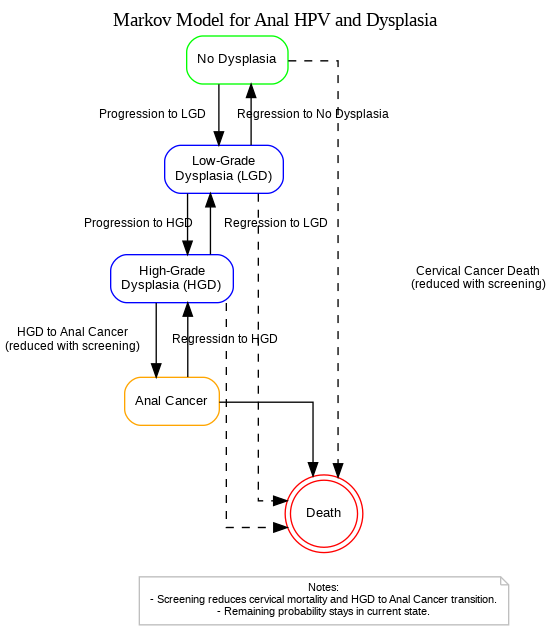

In [31]:
from graphviz import Digraph
from IPython.display import Image, display

# Create directed graph
dot = Digraph(
    comment='Markov Model for Anal HPV and Dysplasia',
    format='png',
    graph_attr={'rankdir': 'TB', 'splines': 'ortho'},
    node_attr={'shape': 'box', 'style': 'rounded', 'fontname': 'Arial', 'fontsize': '10'},
    edge_attr={'fontname': 'Arial', 'fontsize': '9'}
)

# Define states
states = {
    '0': 'No Dysplasia',
    '1': 'Low-Grade\nDysplasia (LGD)',
    '2': 'High-Grade\nDysplasia (HGD)',
    '3': 'Anal Cancer',
    '4': 'Death'
}

# Add nodes
dot.node('0', states['0'], color='green', fontcolor='black')
dot.node('1', states['1'], color='blue', fontcolor='black')
dot.node('2', states['2'], color='blue', fontcolor='black')
dot.node('3', states['3'], color='orange', fontcolor='black')
dot.node('4', states['4'], shape='doublecircle', color='red', fontcolor='black')

# Progression transitions
dot.edge('0', '1', label='Progression to LGD')
dot.edge('1', '2', label='Progression to HGD')
dot.edge('2', '3', label='HGD to Anal Cancer\n(reduced with screening)')
dot.edge('3', '4', label='')

# Background mortality
dot.edge('0', '4', label='Cervical Cancer Death\n(reduced with screening)', style='dashed')
dot.edge('1', '4', label='', style='dashed')
dot.edge('2', '4', label='', style='dashed')

# Regression transitions
dot.edge('1', '0', label='Regression to No Dysplasia')
dot.edge('2', '1', label='Regression to LGD')
dot.edge('3', '2', label='Regression to HGD')

# Legend at bottom
with dot.subgraph() as s:
    s.attr(rank='sink')
    s.node(
        'legend',
        label='Notes:\n- Screening reduces cervical mortality and HGD to Anal Cancer transition.\n- Remaining probability stays in current state.',
        shape='note',
        fontsize='8',
        color='gray75',
        style='filled',
        fillcolor='white'
    )

# Title
dot.attr(labelloc='t')
dot.attr(label='Markov Model for Anal HPV and Dysplasia')

# Render and display
output_path = dot.render('markov_model_with_regression', view=False)
display(Image(filename=output_path))
